In [28]:
# from google.colab import drive
# drive.mount('/content/drive')

# 데이터 살펴보기

In [29]:
import pandas as pd
import os
import string

df = pd.read_csv("ArticlesApril2018.csv")
print(df.columns)

Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')


# 학습용 데이터셋 정의 - dataset_generation.py


In [30]:
import numpy as np
import glob

from torch.utils.data.dataset import Dataset


class TextGeneration(Dataset):
    def clean_text(self, txt):
        # 모든 단어를 소문자로 바꾸고 특수문자를 제거
        txt = "".join(v for v in txt if v not in string.punctuation).lower()
        return txt
    def __init__(self):
        all_headlines = []

        # ❶ 모든 헤드라인의 텍스트를 불러옴
        for filename in glob.glob("ArticlesApril2018.csv"):
            if 'Articles' in filename:
                article_df = pd.read_csv(filename)

                # 데이터셋의 headline의 값을 all_headlines에 추가
                all_headlines.extend(list(article_df.headline.values))
                break

        # ❷ headline 중 unknown 값은 제거
        all_headlines = [h for h in all_headlines if h != "Unknown"]

        # ❸ 구두점 제거 및 전처리가 된 문장들을 리스트로 반환
        self.corpus = [self.clean_text(x) for x in all_headlines]
        self.BOW = {}

        # ➍ 모든 문장의 단어를 추출해 고유번호 지정
        for line in self.corpus:
            for word in line.split():
                if word not in self.BOW.keys():
                    self.BOW[word] = len(self.BOW.keys())

        # 모델의 입력으로 사용할 데이터
        self.data = self.generate_sequence(self.corpus)
    def generate_sequence(self, txt):
        seq = []

        for line in txt:
            line = line.split()
            line_bow = [self.BOW[word] for word in line]

            # 단어 2개를 입력으로, 그다음 단어를 정답으로
            data = [([line_bow[i], line_bow[i+1]], line_bow[i+2])
            for i in range(len(line_bow)-2)]

            seq.extend(data)

        return seq
    def __len__(self):
        return len(self.data)
    def __getitem__(self, i):
        data = np.array(self.data[i][0])  # ❶ 입력 데이터
        label = np.array(self.data[i][1]).astype(np.float32)  # ❷ 출력 데이터

        return data, label

# LSTM모델 정의 - model.py

In [31]:
import torch
import torch.nn as nn


class LSTM(nn.Module):
   def __init__(self, num_embeddings):
       super(LSTM, self).__init__()

       # ❶ 밀집표현을 위한 임베딩층
       self.embed = nn.Embedding(
           num_embeddings=num_embeddings, embedding_dim=16)

       # LSTM을 5개층을 쌓음
       self.lstm = nn.LSTM(
           input_size=16,
           hidden_size=64,
           num_layers=5,
           batch_first=True)

       # 분류를 위한 MLP층
       self.fc1 = nn.Linear(128, num_embeddings)
       self.fc2 = nn.Linear(num_embeddings,num_embeddings)

       # 활성화 함수
       self.relu = nn.ReLU()

   def forward(self, x):
       x = self.embed(x)

       # ❷ LSTM 모델의 예측값
       x, _ = self.lstm(x)
       x = torch.reshape(x, (x.shape[0], -1))
       x = self.fc1(x)
       x = self.relu(x)
       x = self.fc2(x)

       return x

#유틸리티 - utill.py

In [32]:

def calculate_accuracy(preds, y):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == y).float()
    acc = correct.sum() / len(correct)
    return acc

# 모델 학습하기 _ train.py

In [33]:
import torch
import tqdm
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss


# 학습을 진행할 프로세서 정의
device = "cuda" if torch.cuda.is_available() else "cpu"
# 데이터셋 및 모델 설정
dataset = TextGeneration()  # 가정된 데이터셋
model = LSTM(num_embeddings=len(dataset.BOW)).to(device)  # LSTM 모델
optim = Adam(model.parameters(), lr=0.001)  # 옵티마이저
loss_function = CrossEntropyLoss()  # 손실 함수

# 데이터셋 분할 비율 설정
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
total_epoch =50

# 데이터셋 분할
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

#기록 리스트들
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []


# 학습 루프
for epoch in range(total_epoch):
    model.train()
    train_loss = 0
    train_acc = 0
    iterator = tqdm.tqdm(train_loader)
    for data, label in iterator:
        # 기울기 초기화
        optim.zero_grad()

        # 데이터를 device에 로드
        data = torch.tensor(data, dtype=torch.long).to(device)
        label = torch.tensor(label, dtype=torch.long).to(device)

        # 모델의 예측
        pred = model(data)

        # 손실 계산
        loss = loss_function(pred, label)
        acc = calculate_accuracy(pred, label)

        # 역전파 및 최적화
        loss.backward()
        optim.step()
        train_loss += loss.item()
        train_acc += acc.item()

        iterator.set_description(f"epoch{epoch} loss:{loss.item()}")

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    tqdm.tqdm.write(f'Epoch {epoch}: 평균 학습 손실 {avg_train_loss}')

    # 검증 루프
    model.eval()
    val_loss = 0
    valid_acc = 0
    with torch.no_grad():
        for data, label in val_loader:
            data = torch.tensor(data, dtype=torch.long).to(device)
            label = torch.tensor(label, dtype=torch.long).to(device)
            pred = model(data)
            loss = loss_function(pred, label)
            acc = calculate_accuracy(pred, label)

            val_loss += loss.item()
            valid_acc += acc.item()


    avg_val_loss = val_loss / len(val_loader)
    avg_valid_acc = valid_acc / len(val_loader)

    valid_losses.append(avg_val_loss)
    valid_accuracies.append(avg_valid_acc)
    tqdm.tqdm.write(f'Epoch {epoch}: 평균 검증 손실 {avg_val_loss}')



# 모델 저장
torch.save(model.state_dict(), "lstm.pth")

  0%|          | 0/73 [00:00<?, ?it/s]<ipython-input-33-56b28dbb83de>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.long).to(device)
<ipython-input-33-56b28dbb83de>:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long).to(device)
epoch0 loss:8.007111549377441: 100%|██████████| 73/73 [00:29<00:00,  2.47it/s]
<ipython-input-33-56b28dbb83de>:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.long).to(device)
<ipython-input

Epoch 0: 평균 학습 손실 7.679392559887612
Epoch 0: 평균 검증 손실 7.526519954204559


epoch1 loss:8.212067604064941: 100%|██████████| 73/73 [00:29<00:00,  2.51it/s]


Epoch 1: 평균 학습 손실 7.021292320669514
Epoch 1: 평균 검증 손실 7.735877215862274


epoch2 loss:6.828921794891357: 100%|██████████| 73/73 [00:28<00:00,  2.54it/s]


Epoch 2: 평균 학습 손실 6.943178542672771
Epoch 2: 평균 검증 손실 7.939318090677261


epoch3 loss:7.716956615447998: 100%|██████████| 73/73 [00:28<00:00,  2.55it/s]


Epoch 3: 평균 학습 손실 6.937454615553764
Epoch 3: 평균 검증 손실 8.047410756349564


epoch4 loss:7.571218967437744: 100%|██████████| 73/73 [00:27<00:00,  2.61it/s]


Epoch 4: 평균 학습 손실 6.905205014633806
Epoch 4: 평균 검증 손실 8.156296908855438


epoch5 loss:7.2396697998046875: 100%|██████████| 73/73 [00:29<00:00,  2.51it/s]


Epoch 5: 평균 학습 손실 6.80873147755453
Epoch 5: 평균 검증 손실 8.218607366085052


epoch6 loss:6.486174583435059: 100%|██████████| 73/73 [00:27<00:00,  2.67it/s]


Epoch 6: 평균 학습 손실 6.686388179047467
Epoch 6: 평균 검증 손실 8.389684826135635


epoch7 loss:6.581173896789551: 100%|██████████| 73/73 [00:26<00:00,  2.73it/s]


Epoch 7: 평균 학습 손실 6.584841617166179
Epoch 7: 평균 검증 손실 8.51101404428482


epoch8 loss:6.075316905975342: 100%|██████████| 73/73 [00:26<00:00,  2.80it/s]


Epoch 8: 평균 학습 손실 6.462648764048537
Epoch 8: 평균 검증 손실 8.58332222700119


epoch9 loss:6.200962543487549: 100%|██████████| 73/73 [00:26<00:00,  2.74it/s]


Epoch 9: 평균 학습 손실 6.326362237538377
Epoch 9: 평균 검증 손실 9.046244204044342


epoch10 loss:6.694845676422119: 100%|██████████| 73/73 [00:25<00:00,  2.88it/s]


Epoch 10: 평균 학습 손실 6.187026605214158
Epoch 10: 평균 검증 손실 9.176235258579254


epoch11 loss:6.0924072265625: 100%|██████████| 73/73 [00:25<00:00,  2.90it/s]


Epoch 11: 평균 학습 손실 5.993283160745281
Epoch 11: 평균 검증 손실 9.785521268844604


epoch12 loss:5.691797733306885: 100%|██████████| 73/73 [00:25<00:00,  2.81it/s]


Epoch 12: 평균 학습 손실 5.792093453341967
Epoch 12: 평균 검증 손실 9.960992217063904


epoch13 loss:5.4174981117248535: 100%|██████████| 73/73 [00:26<00:00,  2.76it/s]


Epoch 13: 평균 학습 손실 5.590401153041892
Epoch 13: 평균 검증 손실 10.471649587154388


epoch14 loss:5.6640448570251465: 100%|██████████| 73/73 [00:26<00:00,  2.74it/s]


Epoch 14: 평균 학습 손실 5.413388931587951
Epoch 14: 평균 검증 손실 10.841277778148651


epoch15 loss:5.235831260681152: 100%|██████████| 73/73 [00:28<00:00,  2.60it/s]


Epoch 15: 평균 학습 손실 5.233543598488586
Epoch 15: 평균 검증 손실 11.983852863311768


epoch16 loss:5.095496654510498: 100%|██████████| 73/73 [00:30<00:00,  2.39it/s]


Epoch 16: 평균 학습 손실 5.079918155931447
Epoch 16: 평균 검증 손실 12.382310330867767


epoch17 loss:5.7593092918396: 100%|██████████| 73/73 [00:35<00:00,  2.06it/s]


Epoch 17: 평균 학습 손실 4.945711175056353
Epoch 17: 평균 검증 손실 12.849711060523987


epoch18 loss:4.414474010467529: 100%|██████████| 73/73 [00:37<00:00,  1.94it/s]


Epoch 18: 평균 학습 손실 4.810454656000006
Epoch 18: 평균 검증 손실 13.374089300632477


epoch19 loss:4.797811031341553: 100%|██████████| 73/73 [00:38<00:00,  1.91it/s]


Epoch 19: 평균 학습 손실 4.697080011237158
Epoch 19: 평균 검증 손실 13.976348280906677


epoch20 loss:4.670982360839844: 100%|██████████| 73/73 [00:39<00:00,  1.86it/s]


Epoch 20: 평균 학습 손실 4.5857634675012875
Epoch 20: 평균 검증 손실 14.310835301876068


epoch21 loss:4.362708568572998: 100%|██████████| 73/73 [00:39<00:00,  1.83it/s]


Epoch 21: 평균 학습 손실 4.478340998087844
Epoch 21: 평균 검증 손실 14.988044440746307


epoch22 loss:4.624725341796875: 100%|██████████| 73/73 [00:39<00:00,  1.84it/s]


Epoch 22: 평균 학습 손실 4.370353548494104
Epoch 22: 평균 검증 손실 15.496184349060059


epoch23 loss:4.633797645568848: 100%|██████████| 73/73 [00:39<00:00,  1.83it/s]


Epoch 23: 평균 학습 손실 4.2793326639149285
Epoch 23: 평균 검증 손실 16.050457298755646


epoch24 loss:4.21942138671875: 100%|██████████| 73/73 [00:40<00:00,  1.81it/s]


Epoch 24: 평균 학습 손실 4.182454207172133
Epoch 24: 평균 검증 손실 16.560942769050598


epoch25 loss:3.9472413063049316: 100%|██████████| 73/73 [00:41<00:00,  1.78it/s]


Epoch 25: 평균 학습 손실 4.1002990970872855
Epoch 25: 평균 검증 손실 17.011033177375793


epoch26 loss:3.5867371559143066: 100%|██████████| 73/73 [00:40<00:00,  1.80it/s]


Epoch 26: 평균 학습 손실 4.005101350888814
Epoch 26: 평균 검증 손실 17.294744729995728


epoch27 loss:4.093900203704834: 100%|██████████| 73/73 [00:40<00:00,  1.80it/s]


Epoch 27: 평균 학습 손실 3.933463351367271
Epoch 27: 평균 검증 손실 17.52046537399292


epoch28 loss:3.5739681720733643: 100%|██████████| 73/73 [00:40<00:00,  1.81it/s]


Epoch 28: 평균 학습 손실 3.8306985652610046
Epoch 28: 평균 검증 손실 18.216950297355652


epoch29 loss:4.033488750457764: 100%|██████████| 73/73 [00:41<00:00,  1.77it/s]


Epoch 29: 평균 학습 손실 3.738199665121836
Epoch 29: 평균 검증 손실 18.728392243385315


epoch30 loss:3.834390878677368: 100%|██████████| 73/73 [00:39<00:00,  1.84it/s]


Epoch 30: 평균 학습 손실 3.655166028297111
Epoch 30: 평균 검증 손실 19.04712748527527


epoch31 loss:3.775888204574585: 100%|██████████| 73/73 [00:39<00:00,  1.83it/s]


Epoch 31: 평균 학습 손실 3.5658526714533973
Epoch 31: 평균 검증 손실 19.541373133659363


epoch32 loss:3.2475883960723877: 100%|██████████| 73/73 [00:40<00:00,  1.78it/s]


Epoch 32: 평균 학습 손실 3.4807424839228798
Epoch 32: 평균 검증 손실 19.84440553188324


epoch33 loss:3.6960527896881104: 100%|██████████| 73/73 [00:41<00:00,  1.77it/s]


Epoch 33: 평균 학습 손실 3.4140155511359644
Epoch 33: 평균 검증 손실 20.25243854522705


epoch34 loss:3.5899341106414795: 100%|██████████| 73/73 [00:41<00:00,  1.76it/s]


Epoch 34: 평균 학습 손실 3.345191237044661
Epoch 34: 평균 검증 손실 20.476169228553772


epoch35 loss:3.492194890975952: 100%|██████████| 73/73 [00:41<00:00,  1.76it/s]


Epoch 35: 평균 학습 손실 3.277141567778914
Epoch 35: 평균 검증 손실 20.97819197177887


epoch36 loss:3.1781153678894043: 100%|██████████| 73/73 [00:41<00:00,  1.74it/s]


Epoch 36: 평균 학습 손실 3.179389914421186
Epoch 36: 평균 검증 손실 21.25198256969452


epoch37 loss:3.3521792888641357: 100%|██████████| 73/73 [00:42<00:00,  1.73it/s]


Epoch 37: 평균 학습 손실 3.104745812612037
Epoch 37: 평균 검증 손실 21.53387212753296


epoch38 loss:3.310706377029419: 100%|██████████| 73/73 [00:42<00:00,  1.72it/s]


Epoch 38: 평균 학습 손실 3.025073531555803
Epoch 38: 평균 검증 손실 22.07381021976471


epoch39 loss:2.919372797012329: 100%|██████████| 73/73 [00:42<00:00,  1.72it/s]


Epoch 39: 평균 학습 손실 2.943184640309582
Epoch 39: 평균 검증 손실 22.329058051109314


epoch40 loss:3.0990853309631348: 100%|██████████| 73/73 [00:43<00:00,  1.68it/s]


Epoch 40: 평균 학습 손실 2.8990906134043652
Epoch 40: 평균 검증 손실 22.72779941558838


epoch41 loss:3.061711072921753: 100%|██████████| 73/73 [00:42<00:00,  1.71it/s]


Epoch 41: 평균 학습 손실 2.837796740335961
Epoch 41: 평균 검증 손실 22.93630599975586


epoch42 loss:2.8073790073394775: 100%|██████████| 73/73 [00:42<00:00,  1.71it/s]


Epoch 42: 평균 학습 손실 2.744315127803855
Epoch 42: 평균 검증 손실 23.40358304977417


epoch43 loss:2.7536377906799316: 100%|██████████| 73/73 [00:42<00:00,  1.71it/s]


Epoch 43: 평균 학습 손실 2.6632976336021947
Epoch 43: 평균 검증 손실 23.788819551467896


epoch44 loss:2.306556463241577: 100%|██████████| 73/73 [00:43<00:00,  1.69it/s]


Epoch 44: 평균 학습 손실 2.5714690783252454
Epoch 44: 평균 검증 손실 24.2243230342865


epoch45 loss:2.699388027191162: 100%|██████████| 73/73 [00:43<00:00,  1.67it/s]


Epoch 45: 평균 학습 손실 2.5070049403464956
Epoch 45: 평균 검증 손실 24.573120951652527


epoch46 loss:2.7549264430999756: 100%|██████████| 73/73 [00:44<00:00,  1.66it/s]


Epoch 46: 평균 학습 손실 2.4580229716758204
Epoch 46: 평균 검증 손실 24.887773394584656


epoch47 loss:3.0923545360565186: 100%|██████████| 73/73 [00:44<00:00,  1.66it/s]


Epoch 47: 평균 학습 손실 2.4133453352810585
Epoch 47: 평균 검증 손실 25.08818018436432


epoch48 loss:2.980839967727661: 100%|██████████| 73/73 [00:44<00:00,  1.62it/s]


Epoch 48: 평균 학습 손실 2.2908029784894968
Epoch 48: 평균 검증 손실 25.556050062179565


epoch49 loss:2.100391149520874: 100%|██████████| 73/73 [00:44<00:00,  1.64it/s]


Epoch 49: 평균 학습 손실 2.242408620168085
Epoch 49: 평균 검증 손실 25.84407901763916


    Epoch  Train Loss  Validation Loss  Train Accuracy  Validation Accuracy
0       1    7.679393         7.526520        0.029324             0.028451
1       2    7.021292         7.735877        0.030180             0.028451
2       3    6.943179         7.939318        0.032534             0.028451
3       4    6.937455         8.047411        0.029966             0.028451
4       5    6.905205         8.156297        0.030394             0.032357
5       6    6.808731         8.218607        0.032534             0.033333
6       7    6.686388         8.389685        0.034583             0.029557
7       8    6.584842         8.511014        0.036387             0.031510
8       9    6.462649         8.583322        0.039292             0.036263
9      10    6.326362         9.046244        0.044429             0.039453
10     11    6.187027         9.176235        0.046355             0.039453
11     12    5.993283         9.785521        0.048373             0.042253
12     13   

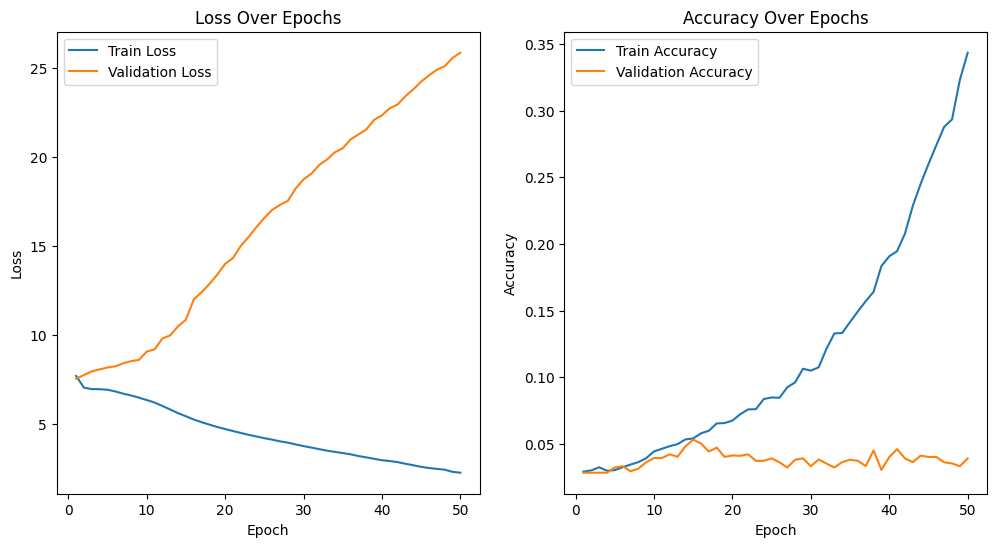

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 준비
data = {
    "Epoch": range(1, total_epoch + 1),
    "Train Loss": train_losses,
    "Validation Loss": valid_losses,
    "Train Accuracy": train_accuracies,
    "Validation Accuracy": valid_accuracies
}

# DataFrame 생성
df = pd.DataFrame(data)

# DataFrame 출력
print(df)

# 시각화
plt.figure(figsize=(12, 6))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(df["Epoch"], df["Train Loss"], label="Train Loss")
plt.plot(df["Epoch"], df["Validation Loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(df["Epoch"], df["Train Accuracy"], label="Train Accuracy")
plt.plot(df["Epoch"], df["Validation Accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


# 테스트 _ test.py

In [35]:
# 테스트 루프
model.eval()
test_loss = 0
with torch.no_grad():
    for data, label in test_loader:
        data = torch.tensor(data, dtype=torch.long).to(device)
        label = torch.tensor(label, dtype=torch.long).to(device)

        pred = model(data)
        loss = loss_function(pred, label)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f'테스트 손실: {avg_test_loss}')

<ipython-input-35-863023b97202>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.long).to(device)
<ipython-input-35-863023b97202>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.long).to(device)


테스트 손실: 26.11001443862915


#문장 생성하기 predict.py

In [36]:
def generate(model, BOW, string="finding my ", strlen=2):
   device = "cuda" if torch.cuda.is_available() else "cpu"

   print(f"input word: {string}")

   with torch.no_grad():
       for p in range(strlen):
           # 입력 문장을 텐서로 변경
           words = torch.tensor(
               [BOW[w] for w in string.split()], dtype=torch.long).to(device)

           # ❶
           input_tensor = torch.unsqueeze(words[-2:], dim=0)
           output = model(input_tensor)  # 모델을 이용해 예측
           output_word = (torch.argmax(output).cpu().numpy())
           string += list(BOW.keys())[output_word]  # 문장에 예측된 단어를 추가
           string += " "

   print(f"predicted sentence: {string}")

model.load_state_dict(torch.load("lstm.pth", map_location=device))
pred = generate(model, dataset.BOW)

input word: finding my 
predicted sentence: finding my expresident states 
